In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import wine_prep
from plotting_functions import nn_plot_mse
from enkf_functions import enkf_regressor
from saving_functions import load_objects, save_objects
from model_functions import nn_load, nn_model_structure, nn_model_compile
import reproducible
import no_gpu
from sklearn.metrics import mean_squared_error
import numpy as np

In [4]:
X_train, X_test, y_train, y_test = wine_prep()

In [6]:
layers = 4
neurons = [32, 32, 16, 1]

In [92]:
def enkf_regressor_analysis(X_train,
                            X_test,
                            y_train,
                            y_test,
                            layers,
                            neurons,
                            setting_dict,
                            analysis_dict,
                            save_all = False,
                            file_var = "file.pckl",
                            file_model = "file.h5",
                            verbose = 0
                            ):

    """ Ensemble Kalman Filter algorithm analysis for regression problems.


    Parameters:

    X_train (np.ndarray): Training data X.
    X_test (np.ndarray): Test data X.
    y_train (pd.DataFrame): Training data y.
    y_test (pd.DataFrame): Test data y.
    layers (int): Number of layers.
    neurons (list): Number of neurons in each layer.
    setting_dict (dict): Dictionary containing
        particles (int): Number of particles in the ensemble.
        epochs (int): Number of epochs.
        batch_size (None or int): Size of the batches. Must be between 0 and the number of observations in the training set.
        h_0 (int or float): Starting step size.
        delta (float): Constant for numerical stability in the jacobian.
        epsilon (float): Constant for numerical stability in the step size.
        shuffle (bool): Whether or not to shuffle the data prior to each epoch.
        early_stopping (float or None): Minimum change before early stopping is applied.
    analysis_dict (dict): Dictionary containing
        disjoint_batch (bool): Whether or not to use disjoint batches. If False then each batch is sampled with replacement.
        batch_particle_connection (dict): Dictionary containing
            connect (bool): Whether or not to connect particles and batches.
            shuffle (str or None): Whether or not and how to shuffle the connection. None = no shuffle. "permute" = change the allocation of the existing batches and particle sets. "particle" = shuffle the particle sets for fixed batches. "batch" = shuffle the batch for fixed particle sets. "full" = shuffle the particle sets and their corresponding batch.
        tikhonov (dict): Dictionary containing
            regularize (bool): Whether or not to use Tikhonov regularization.
            lambda (None or float): Lambda parameter in Tikhonov regularization. 
    save_all (bool): Whether or not to save all important variables and models.
    file_var (str): Path and name of the file to save variables into.
    file_model (str): Path and name of the file to save the final model into.
    verbose (int): If 0, then don't print anything throughout the training process. If 1, then print training and test accuracy after each epoch.


    Returns:

    mean_model (tensorflow.python.keras.engine.sequential.Sequential): The final model.

    """

    particles = setting_dict["particles"]
    epochs = setting_dict["epochs"]
    batch_size = setting_dict["batch_size"]
    h_0 = setting_dict["h_0"]
    delta = None
    epsilon = setting_dict["epsilon"]
    shuffle = setting_dict["shuffle"]
    early_stopping = setting_dict["early_stopping"]
    
    disjoint_batch = analysis_dict["disjoint_batch"]
    batch_particle_connection = analysis_dict["batch_particle_connection"]["connect"]
    batch_particle_shuffle = analysis_dict["batch_particle_connection"]["shuffle"]
    tik_regularize = analysis_dict["tikhonov"]["regularize"]
    tik_lambda = analysis_dict["tikhonov"]["lambda"]
    if not tik_regularize:
        tik_lambda = None
    if tik_regularize and tik_lambda is None:
        tik_lambda = 0
        
    def regularize_pred(y_pred, weights):
        if tik_regularize and tik_lambda != 0:
            return np.hstack([y_pred.ravel(), np.sqrt(tik_lambda) * weights])
        else:
            return y_pred.ravel()
    
    def regularize_true(y_true, weights):
        if tik_regularize and tik_lambda != 0:
            return np.hstack([y_true, np.zeros(shape = weights.shape)])
        else:
            return y_true.ravel()
    
    if batch_size == None:
        batch_size = len(X_train)

    n_cols = X_train.shape[1]
    
    if disjoint_batch:
        n = len(X_train)
        num_batches = int(np.ceil(n / batch_size))
        batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
        batch_indices[-1] = n
    else:
        n = len(X_train)
        num_batches = int(np.ceil(n / batch_size))
        last_batch_size = n % batch_size
     
    if batch_particle_connection:
        batch_particle_dict = {}
        batch_particle_indices = np.arange(particles) + 1
        np.random.shuffle(batch_particle_indices)
        if particles == num_batches:
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
        elif particles > num_batches:
            base_batches = particles // num_batches
            add_batches = particles % num_batches
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                batch_particle_indices = batch_particle_indices[base_batches:]
            for i in range(add_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
        elif num_batches > particles:
            num_reps = int(np.ceil(num_batches / particles))
            particles_repeated = np.tile(batch_particle_indices, num_reps)
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
    else:
        batch_particle_dict = None

    model_dict = {}
    weights_dict = {}
    y_pred_dict = {}
    jacobian_dict = {}
    weights_vector_dict = {}
    train_mse_dict = {}
    test_mse_dict = {}

    # init_model already has weights and biases following the Glorot distribution
    # it can already be used to predict and evaluate, but it is very bad
    # only used to determine shapes and shape_elements via its weights
    init_model = nn_model_structure(layers = layers,
                                    neurons = neurons,
                                    n_cols = n_cols,
                                    kernel_regularizer_lambda = tik_lambda,
                                    bias_regularizer_lambda = tik_lambda,
                                    classification = False)
    init_model = nn_model_compile(init_model,
                                  optimizer = "sgd")
    weights = init_model.get_weights()
    # shape contains the shapes of the weight matrices and bias vectors as a list of arrays
    shapes = [np.array(params.shape) for params in weights]
    # shape_elements contains the indices of the weights as a vector and tells where to cut
    shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

    for i in range(particles):
        
        # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization, Tikhonov regularization
        model = nn_model_structure(layers = layers,
                                   neurons = neurons,
                                   n_cols = n_cols,
                                   kernel_regularizer_lambda = tik_lambda,
                                   bias_regularizer_lambda = tik_lambda,
                                   classification = False)
        model = nn_model_compile(model,
                                 optimizer = "sgd")
        # for every particle write the model in a dictionary
        model_dict["model_{}".format(str(i+1))] = model

        # for every particles write the weights and biases in a dictionary
        weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                        .get_weights()
        
        # for every particle write the predictions on the training batches in a dictionary
        weights_array_tik = np.array([])
        for j in range(len(weights_dict["model_{}".format(str(i+1))])):
            weights_array_tik = np.append(weights_array_tik, weights_dict["model_{}".format(str(i+1))][j].ravel())        
        y_pred_dict["model_{}".format(str(i+1))] = regularize_pred(model_dict["model_{}".format(str(i+1))]\
                                                                        .predict(X_train[:batch_size,:]),
                                                                   weights_array_tik)

        # for every particle write the Jacobian in a dictionary
        jacobian_dict["model_{}".format(str(i+1))] = 1/len(regularize_true(y_train[:batch_size], weights_array_tik)) * (-2)*(regularize_true(y_train[:batch_size], weights_array_tik) - y_pred_dict["model_{}".format(str(i+1))].ravel())

        train_mse_dict["model_{}".format(str(i+1))] = []
        test_mse_dict["model_{}".format(str(i+1))] = []

    # mean_model as the model with the mean of the weights of all particle models
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model = init_model
    mean_model.set_weights(mean_weights)

    mean_model_train_mse = np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1])
    mean_model_test_mse = np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1])

    # loop over all epochs
    for epoch in range(epochs):
        
        # early stopping
        if early_stopping is not None:
            if epoch == 0:
                train_mse_old = 0
                test_mse_old = 0
            else:
                train_mse_new = mean_model_train_mse[epoch]
                test_mse_new = mean_model_test_mse[epoch]
                if np.absolute(test_mse_new - test_mse_old) <= early_stopping and np.absolute(train_mse_new - train_mse_old) <= early_stopping:
                    print("STOP: Early Stopping after epoch {} because improvement in training MSE is only {} and in test mse only {}."\
                                                                         .format(epoch, train_mse_new - train_mse_old, test_mse_new - test_mse_old))
                    break
                test_mse_old = test_mse_new
                                                                                    
        # shuffle the data
        if shuffle:
            indices = y_train.sample(frac=1).index
        else:
            indices = y_train.index
            
        if disjoint_batch:
            X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
            y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
            y_batches = [np.array(i) for i in y_batches]
        else:
            if last_batch_size != 0:
                indices = [np.random.choice(len(X_train), size = batch_size, replace = True) for i in range(num_batches-1)]
                indices.append(np.random.choice(len(X_train), size = last_batch_size, replace = True))
            else:
                indices = [np.random.choice(len(X_train), size = batch_size, replace = True) for i in range(num_batches)]
            X_batches = [X_train[indices[i]] for i in range(len(indices))]
            y_batches = [y_train[indices[i]] for i in range(len(indices))]
        
        # shuffling for batch particle connection
        if batch_particle_connection and batch_particle_shuffle == "permute":
            shuffled_indices = np.hstack(list(batch_particle_dict.values()))
            np.random.shuffle(shuffled_indices)
            batch_particle_values = list(batch_particle_dict.values())
            for i in range(len(batch_particle_values)):
                batch_particle_dict["batch_{}".format(str(i+1))] = shuffled_indices[i*len(batch_particle_values[i]):(i+1)*len(batch_particle_values[i])]
        if batch_particle_connection and (batch_particle_shuffle == "particle" or batch_particle_shuffle == "full"):
            batch_particle_dict = {}
            batch_particle_indices = np.arange(particles) + 1
            np.random.shuffle(batch_particle_indices)
            if particles == num_batches:
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
            elif particles > num_batches:
                base_batches = particles // num_batches
                add_batches = particles % num_batches
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                    batch_particle_indices = batch_particle_indices[base_batches:]
                for i in range(add_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
            elif num_batches > particles:
                num_reps = int(np.ceil(num_batches / particles))
                particles_repeated = np.tile(batch_particle_indices, num_reps)
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
        if batch_particle_connection and (batch_particle_shuffle == "batch" or batch_particle_shuffle == "full"):
            indices = np.arange(n)
            np.random.shuffle(indices)
            if disjoint_batch:
                X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
                y_batches = [y_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
            else:
                if last_batch_size != 0:
                    indices = [np.random.choice(X_train.shape[0], size = batch_size, replace = True) for i in range(num_batches-1)]
                    indices.append(np.random.choice(X_train.shape[0], size = last_batch_size, replace = True))
                else:
                    indices = [np.random.choice(X_train.shape[0], size = batch_size, replace = True) for i in range(num_batches)]
                X_batches = [X_train[indices[i]] for i in range(len(indices))]
                y_batches = [y_train[indices[i]] for i in range(len(indices))]
               
        # loop over all batches
        for b in range(num_batches):
            batch_particles = []
            for i in range(particles):
                if batch_particle_connection: 
                    if num_batches == particles or num_batches > particles:
                        if batch_particle_dict["batch_{}".format(str(b+1))] != i+1:
                            continue
                    else:
                        if i+1 not in batch_particle_dict["batch_{}".format(str(b+1))]:
                            continue
                if batch_particle_connection:
                    batch_particles.append(i+1)

                # set new weights for model
                model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])

                # for every particle write the predictions on the training batches in a dictionary
                weights_array_tik = np.array([])
                for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                    weights_array_tik = np.append(weights_array_tik, weights_dict["model_{}".format(str(i+1))][j].ravel())
                y_pred_dict["model_{}".format(str(i+1))] = regularize_pred(model_dict["model_{}".format(str(i+1))]\
                                                                                .predict(X_batches[b]),
                                                                           weights_array_tik)
                
                # for every particle write the Jacobian in a dictionary
                jacobian_dict["model_{}".format(str(i+1))] = 1/len(regularize_true(y_batches[b], weights_array_tik)) * (-2)*(regularize_true(y_batches[b], weights_array_tik) - y_pred_dict["model_{}".format(str(i+1))].ravel())

            if not batch_particle_connection:        
                # compute the mean of the predictions
                y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

                # compute the matrix D elementwise
                d = np.zeros(shape = (particles, particles))
                for k in range(particles):
                    y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
                    for j in range(particles):
                        d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
                d = np.transpose(d)

                # compute the scalar h_t
                h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

                # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
                for i in range(particles):
                    weights_array = np.array([])
                    for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                        weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
                    weights_vector_dict["model_{}".format(str(i+1))] = weights_array

                # matrix with particle parameters as row vectors
                weights_all_ptcls = np.array(list(weights_vector_dict.values()))

                # compute the matrix with the updates for each particle
                weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

                for i in range(particles):
                    # write the updates back into the dictionary
                    weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
                    # reshape the updates, so that they are of the original matrx and vector shape
                    for l in range(len(shape_elements)-1):
                        start = shape_elements[l]
                        end = shape_elements[l+1]
                        weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
                
        if batch_particle_connection:
            # compute the mean of the predictions
            y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

            # compute the matrix D elementwise
            d = np.zeros(shape = (particles, particles))
            for k in range(particles):
                y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
                for j in range(particles):
                    d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
            d = np.transpose(d)

            # compute the scalar h_t
            h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

            # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
            for i in range(particles):
                weights_array = np.array([])
                for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                    weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
                weights_vector_dict["model_{}".format(str(i+1))] = weights_array

            # matrix with particle parameters as row vectors
            weights_all_ptcls = np.array(list(weights_vector_dict.values()))

            # compute the matrix with the updates for each particle
            weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

            for i in range(particles):
                # write the updates back into the dictionary
                weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
                # reshape the updates, so that they are of the original matrx and vector shape
                for l in range(len(shape_elements)-1):
                    start = shape_elements[l]
                    end = shape_elements[l+1]
                    weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
                                                            
        for i in range(particles):
            # for every particle write the training MSE of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])

            # for every particle write the test MSE of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])

        # update the mean_model
        mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
        mean_model.set_weights(mean_weights)

        mean_model_train_mse = np.append(mean_model_train_mse, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
        mean_model_test_mse = np.append(mean_model_test_mse, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1])) 

        if verbose == 1:
            print("Epoch {}. Training MSE: {}, Test MSE: {}.".format(epoch+1,
                                                                     np.round(mean_model_train_mse[-1], 3),
                                                                     np.round(mean_model_test_mse[-1], 3)))
            
    mean_model.history.history = {"mse": mean_model_train_mse[1:],
                                  "val_mse": mean_model_test_mse[1:]}
        
    if save_all:
        param_dict = param_to_dict(X_train,
                                   X_test,
                                   y_train,
                                   y_test,
                                   layers,
                                   neurons,
                                   particles,
                                   epochs,
                                   batch_size,
                                   h_0,
                                   delta,
                                   epsilon,
                                   shuffle,
                                   early_stopping
                                   )
        results_dict = results_to_dict(mean_model_train_mse,
                                       mean_model_test_mse,
                                       train_mse_dict,
                                       test_mse_dict,
                                       weights_dict,
                                       y_pred_dict,
                                       False
                                       )

        saving_dict = {}
        saving_dict["parameters"] = param_dict
        saving_dict["results"] = results_dict
        saving_dict["analysis"] = analysis_dict

        save_objects(obj_dict = saving_dict,
                     file = file_var)

        nn_save(model = mean_model,
                path_name = file_model)
 
    return mean_model

# Regularization

In [90]:
setting_dict = {"particles": 100,
                "epochs": 20,
                "batch_size": len(X_train),    # len(X_train)
                "h_0": 2,
                "epsilon": 0.5,
                "shuffle": True,
                "early_stopping": None
               }

In [86]:
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": False,
                                               "shuffle": "particle"},        # None, "permute", "particle", "batch", "full"
                 "tikhonov": {"regularize": True,
                              "lambda": 1}
                }

In [93]:
reg_model = enkf_regressor_analysis(X_train,
                                    X_test,
                                    y_train,
                                    y_test,
                                    layers,
                                    neurons,
                                    setting_dict,
                                    analysis_dict,
                                    save_all = False,
                                    file_var = "../objects/wine/wine_enkf_E{}_B{}_P{}_H{}_Reg.pckl".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                    file_model = "../models/wine/wine_enkf_E{}_B{}_P{}_H{}_Reg.h5".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                    verbose = 1)

Epoch 1. Training MSE: 18.367, Test MSE: 18.323.
Epoch 2. Training MSE: 9.559, Test MSE: 9.548.
Epoch 3. Training MSE: 5.85, Test MSE: 5.859.
Epoch 4. Training MSE: 3.75, Test MSE: 3.779.
Epoch 5. Training MSE: 2.592, Test MSE: 2.617.
Epoch 6. Training MSE: 1.704, Test MSE: 1.73.
Epoch 7. Training MSE: 1.296, Test MSE: 1.318.
Epoch 8. Training MSE: 1.199, Test MSE: 1.226.
Epoch 9. Training MSE: 1.141, Test MSE: 1.162.
Epoch 10. Training MSE: 1.115, Test MSE: 1.136.


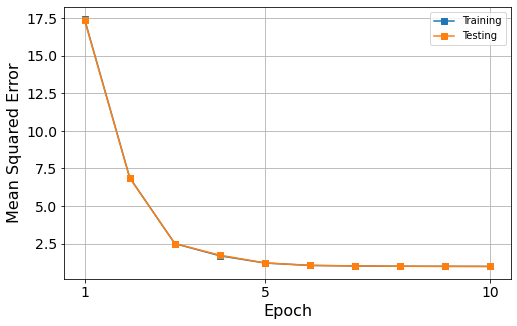

In [85]:
nn_plot_mse(reg_model,
            mse_mean = None,
            start_epoch = 1,
            save = None)#"../img/wine/wine_enkf_E{}_B{}_P{}_H{}_Reg.png".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]))

# BPC

In [ ]:
setting_dict = {"particles": 181,
                "epochs": 20,
                "batch_size": 23,    # len(X_train)
                "h_0": 2,
                "epsilon": 0.5,
                "shuffle": True,
                "early_stopping": None
               }

In [ ]:
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": True,
                                               "shuffle": "particle"},        # None, "permute", "particle", "batch", "full"
                 "tikhonov": {"regularize": False,
                              "lambda": 1}
                }

In [ ]:
bpc_model = enkf_regressor_analysis(X_train,
                                    X_test,
                                    y_train,
                                    y_test,
                                    layers,
                                    neurons,
                                    setting_dict,
                                    analysis_dict,
                                    save_all = False,
                                    file_var = "../objects/wine/wine_enkf_E{}_B{}_P{}_H{}_BPC.pckl".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                    file_model = "../models/wine/wine_enkf_E{}_B{}_P{}_H{}_BPC.h5".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                    verbose = 1)

In [ ]:
nn_plot_mse(bpc_model,
            mse_mean = None,
            start_epoch = 1,
            save = None)#"../img/wine/wine_enkf_E{}_B{}_P{}_H{}_BPC.png".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]))

# Normal

In [ ]:
setting_dict = {"particles": 181,
                "epochs": 20,
                "batch_size": len(X_train),    # len(X_train)
                "h_0": 2,
                "epsilon": 0.5,
                "shuffle": True,
                "early_stopping": None
               }

In [ ]:
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": True,
                                               "shuffle": "particle"},        # None, "permute", "particle", "batch", "full"
                 "tikhonov": {"regularize": False,
                              "lambda": 1}
                }

In [ ]:
eki_model = enkf_regressor_analysis(X_train,
                                    X_test,
                                    y_train,
                                    y_test,
                                    layers,
                                    neurons,
                                    setting_dict,
                                    analysis_dict,
                                    save_all = False,
                                    file_var = "../objects/wine/wine_enkf_E{}_B{}_P{}_H{}.pckl".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                    file_model = "../models/wine/wine_enkf_E{}_B{}_P{}_H{}.h5".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                    verbose = 1)

In [ ]:
nn_plot_mse(eki_model,
            mse_mean = None,
            start_epoch = 1,
            save = None)#"../img/wine/wine_enkf_E{}_B{}_P{}_H{}.png".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]))